In [1]:
import os 
import pandas as pd
import numpy as np
import subprocess
import sys
import shutil
from distutils.dir_util import copy_tree
import distutils
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import timeit



%matplotlib notebook


In [2]:
## Functions ##

### The rain gage file maker function for a SINGLE rain gauge ### 
"""
Note that this will modify the PrjName.gag file as well as the PrjName.prj file to update the run length to match the precip.gag length

PrjName   =  the project name under which the WMS file is saved
Input_Precip_df - A dataframe of timerseries precipitation data Note that this has to be in memory INSIDE of the current script
Precip_column_Name - The column in the above Input_Precip_df to use
StartDate - Desired start date of the run (note will work if no hours or minutes but best to add them)
EndDate  - Desired end date of the run 
Lat lon of the gauge site, important for GSSHA calculations  (Needs to be formatted as string) 
RainSeries_timestep_Mins - The timestep of the input rainfall data from Input_Precip_df
PrjDir    = can be specified if its not in a RUN subdirectory of the pwd
ImpPrecip_units - Units of the precip df, has to either be 'Inches' or 'mm
GageName - name of gauge, not so important
"""
    
def make_rain_gag_file(PrjName, Input_Precip_df, Precip_column_Name, StartDate, EndDate, Lat, Lon, 
                        RainSeries_timestep_Mins, ImpPrecip_units, PrjDir = os.path.join('.', 'RUN'), GageName="mooface"):

    # read in data 
    SliceFrame = Input_Precip_df[StartDate:EndDate]

    # Format date string for dumb file 
    SliceFrame_format = SliceFrame.copy()
    SliceFrame_format['da'] = SliceFrame_format.index.strftime('%Y %m %d %H %M')
    SliceFrame_format['datedumb'] = SliceFrame_format['da'].str[:]

    # Pull extranious columns 
    SliceFrame_format = SliceFrame_format[['datedumb', Precip_column_Name]]
    SliceFrame_format.rename(columns={Precip_column_Name: 'Rainfall'}, inplace=True)
    
    
    # Abort mission if there are any missing values in the data, GSSHA will not run with mising rain values 
    if SliceFrame_format.isnull().values.any():
        print("Mission aborted, there are NaN values in the rain data, please fix your data or choose different dates")
        
        return 0,0
    
    # Turn rain in to rain MM if its in inches to start with which is the default
    if ImpPrecip_units == "Inches": 
        SliceFrame_format['Rainfall'] = SliceFrame_format['Rainfall']*25.4 

        
    # Round off the number of significant figs
    sigfigs = 3
    SliceFrame_format['Rainfall'] = SliceFrame_format['Rainfall'].round(sigfigs).apply(lambda x: 
                                                                                                 '{0:g}'.format(float(x)))
    # Put the GAGES card on EVery single row 
    SliceFrame_format["trash"] = "GAGES"

    # reorder columns 
    SliceFrame_format = SliceFrame_format[["trash", "datedumb", 'Rainfall']]

    # Print it off to a txt file with no header, no index and space separator
    FileNamePlace = os.path.join(PrjDir, "{}.gag".format(PrjName))
    SliceFrame_format.to_csv(FileNamePlace, index=False, sep=' ', header = False) 

    # Remove dumb double quotes from the pandas to csv (could probably clean up and use numpy instead if ambitious...)
    with open(FileNamePlace,'r') as file:
        data = file.read()
        data = data.replace('"','')
    with open(FileNamePlace,'w') as file:    
        file.write(data)

    # Create the required header lines for WMS gag  files 
    AddLine = 'EVENT "Rain Gage" \nNRGAG 1 \nNRPDS {}\nCOORD {} {} "{}"'.format(len(SliceFrame_format),Lat, Lon, GageName)  

    with open(FileNamePlace, "r+") as f:
        old = f.read() # read everything in the file
        f.seek(0) # rewind
        f.write("{}\n".format(AddLine) + old) # write the new line before

    # Calculate the number of minutes to run the damn thing. 
    Run_Length_mins = RainSeries_timestep_Mins*len(SliceFrame_format)
    #print("Simulation time is {} minutes".format(Run_Length_mins))
    #print("number of time rows is {}".format(len(SliceFrame_format)))
    
    
    #  Now open and modify the .prj file to run at the new timestep
    card_name = "TOT_TIME"   # THIS is the card we change for the rainfall function here
    df = pd.read_csv(os.path.join(PrjDir, "{}.prj".format(PrjName)), names=["moo"] )  
    # note names=moo is to make a column that will then get chopped off by numpy savetxt
    singleCol = df.columns[0]     # All data was read into a single column with pandas
    idx_tottime = df.loc[df[singleCol].str.contains(card_name, case=False)].index[0]  # this identifies the index of the TOT_TIME card
    df.loc[idx_tottime] = "{}        {}".format(card_name, Run_Length_mins)
    
    # Save the df back to a prj file (the np formulation seems to write better than the pd to csv one)
    np.savetxt(os.path.join(PrjDir, "{}.prj".format(PrjName)), df.values, fmt="%s")
    
    
    return Run_Length_mins, SliceFrame_format       






### Run a command line version of GSSHA model   ###
''' 
PrjName = the project name under which the WMS file is saved (be sure to save the WMS file INSIDE of the RUN directory)
RUN_dir = the RELATIVE or ABSOLUTE PATH to the directory where the project files are saved 
'''

def run_GSSHA(PrjName, RUN_dir):
    
    start_time = timeit.default_timer()     ###### Timer function start
    try: 
        # note GSSHA.exe has to be in the pwd of the kernal NOT the RUN directory
        subprocess.call('gssha.exe {}.prj'.format(PrjName),  cwd=RUN_dir) # shell=True)   
    except: print("FAILED execution!! check to see, GSSHA.exe has to be in the pwd of the notebook kernal NOT in the RUN directory, AND check to see if the absolute paths in the .prj file are correct, have to save from WMS into the pwd")
        
    elapsed = timeit.default_timer() - start_time        ###### Timer function End, now time in seconds lives in elapsed
    return elapsed
        
### Process outlet file from GSSHA into a pandas dataframe  ###
'''
StartDate = the start date and time of the run, in this format with hours and minutes "2018-08-23 00:00"
PrjName   =  the project name under which the WMS file is saved
PrjDir    = can be specified if its not in a RUN subdirectory of the pwd
'''
def process_otl_file(StartDate, PrjName, PrjDir = os.path.join('.', 'RUN')):

    # Create the start time object to enumerate the number of minutes in the outlet file 
    StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')
    
    # read in the outlet file 
    OutletFile = os.path.join(PrjDir, PrjName+".otl") 
    OutHydro = pd.read_csv(OutletFile, names=["Minutes", "CFS"], delim_whitespace=True)
    
    # da magic: Turn stupid minutes into useful datetime objects 
    OutHydro["date"] = OutHydro["Minutes"].apply(lambda x: StartDateTime + timedelta(minutes=x))
    
    # Set the index to the date
    OutHydro.set_index("date", inplace=True)
    
    return OutHydro




        
#### Plot stuff  

'''
OutHydro   =    The output data from the model run, processed by the process_otl_file funciton 
SlicedStreamflow_df   = The processed stream flowdataframe from the Isolate_Stream_Data function 
StreamFlow_column_Name = The column name of the streamflow data 
Rain_Data_Frame =    T the rainfall data for the given run as produced by the make_rain_gag_file fucntion 
RunID  =  The ID composed of the parameter name and its value for identifying figures later composed in the iteration cell 
elapsed =  The amount of time the model took to run from the rub model function 
Save   = If you want to save the figure 
FigFolder = the path to where you want the figure saved 

'''

def Plot_and_Compare(OutHydro, SlicedStreamflow_df, Rain_Data_Frame, RunID, elapsed, 
                     Save=True, FigFolder=os.path.join(".", "Figures")): 
    
    # Calculating NSE
    targets = SlicedStreamflow_df.resample('60T').mean().interpolate()
    NSE_Frame = OutHydro.join(targets, how='inner')
    NSE_stat = nse(NSE_Frame['CFS'].values, NSE_Frame["Streamflow"].values)
    print("The NSE is {}".format(NSE_stat))
    
        # Plotting 
    # For some reason need to cast the rainfall as a number not object?
    Rain_Data_Frame['Rainfall'] = Rain_Data_Frame['Rainfall'].apply(lambda x: float(x)) 
    fig, ax = plt.subplots(figsize=(8, 3))
    ax2 = ax.twinx()
    lns0 = ax2.plot(Rain_Data_Frame['Rainfall'], '.', c='b', alpha=0.4, label="Rainfall ")   # Plot rainfall 
    lns1 = ax.plot(SlicedStreamflow_df['Streamflow'], '-', c='g', alpha=0.5, label="Observed Waihehe flow CFS") # Plot Observed
    lns2 = ax.plot(OutHydro['CFS'], '-', c='k', alpha=0.5, label="Modeled_CFS")   # plot modeled 
    ax.set_ylabel("Flow CFS")
    ax2.set_ylabel("Rainfall mm", color='b')
    # Wierd stuff for a twinned  axis legend
    lns = lns0+lns1+lns2; labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    
    plt.title("{} - NSE={}, time={}_sec".format(RunID,
                                             round(NSE_stat, 2), round(elapsed, 0)))
    # save fig
    if Save:
        Startrun = str(Rain_Data_Frame.index[0])
        Startrun = Startrun[:10]
        Endrun   = str(Rain_Data_Frame.index[-1])
        Endrun   = Endrun[:10] 
        plt.savefig(os.path.join(FigFolder, "{}-{}-to-{}.png".format(RunID, Startrun, Endrun)))


        
######## Processing the Max flood file into ASCII raster map  ######## 
"""
gfl_file = the name and location of the .gfl max flood depth file 
NumRowsCells =  The number of rows of cells in the model, i.e. N-S dimension length 
NumCols_Cells = The number of Columns of cells in the model i.e. E-W dimension length 
cellsize = The size of cells (in m) for the ASCII grid
xll The Easting UTM coordinate of the Lower Left cell of the model domain, 
yll The Northing UTM coordinate of the Lower Left cell of the model domain, 
### note that the ASC is based on the center of the Lower Left cell, whereas its easiest to see the corner, so some math needs to be done 
no_data_val = put in whatever here
Save_filename = the filename to which the .asc will be saved
Save_FilePlace = The place to save the asc raster 
PLOT = True and it will plot in the notebook
SAVE = True and it will save the asc file, false it wont
"""


def WMS_Max_Flood_File_to_ASCii(gfl_file, NumRowsCells, NumCols_Cells,
                           cellsize, xll, yll, no_data_val, Save_filename, Save_FilePlace, 
                                PLOT=True, SAVE=False):
    
    NumCELLS = NumRowsCells* NumCols_Cells

    arr = np.genfromtxt(gfl_file, skip_header=8, delimiter=',')    # delimit with a comma to keep it from using spaces...
    arr = arr[:-1]   # Cut off the last row which says ENDDS
    arr_activecells = arr[0:NumCELLS]
    arr_datacells   =  arr[NumCELLS:]

    gridmo = np.reshape(arr_datacells, (NumRowsCells, NumCols_Cells))
    
    if PLOT: 
        # plot it in python 
        fig, ax = plt.subplots(figsize=(8, 3))
        plt.imshow(gridmo, cmap='gray')      # Plot the data using imshow with gray colormap

    if SAVE:    
        # Save the ASCii File 
        headerstring       = bytes('NCOLS %d\nNROWS %d\nXLLCENTER %f\nYLLCENTER %f\nCELLSIZE %f\nNODATA_value %f\n' % 
            (gridmo.shape[1], gridmo.shape[0], xll, yll, cellsize, no_data_val), 'UTF-8')
        with open(os.path.join(Save_FilePlace, "{}.asc".format(Save_filename)),'wb') as fout:
            fout.write(headerstring)
            np.savetxt(fout,gridmo,'%5.2f')

        # Save the projection file for ArcGIS (Projection might need to be changed depending on WMS projection?) 
        epsg = 'PROJCS["WGS_1984_UTM_Zone_4N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-159],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32604"]],VERTCS["Local",VDATUM["Local"],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]'
        with open(os.path.join(Save_FilePlace, "{}.prj".format(Save_filename)), "w") as prj:
            prj.write(epsg)
            prj.close()

        print("Saved {}.asc at {}".format(Save_filename, Save_FilePlace))
    
    return gridmo
        
                     

In [9]:
## Basic model parameters 
PrjName = 'Iao_Soil_Initial_Precip_0p4'

Input_Precip_File = os.path.join(".", "data/Precip", "PUU_KUKIv2.csv") # reads in a rainfall file into memory, 

Precip_column_Name = "RF_mm"
# Event Variables 
StartDate   =  "2016-09-13 07:00"
EndDate     =    "2016-09-14 07:00"
RainSeries_timestep_Mins = 60
Lat  = "753250.0"      # For Waihehe 753354,    # For WaiehuKou,"758000.0"    # for Iao 753250
Lon  = "2310140.0"      # For Waihehe 2314472,   # For WaiehuKou,"2315555.0"   # for Iao 2310140
RUN_dir = os.path.join('.', 'RUN')


# Max flood grid parameters
gfl_file  =  os.path.join('.', "RUN", '{}.gfl'.format(PrjName))
# Cell geometry from the WMS model 
NumRowsCells        = 84
NumCols_Cells       = 111
# ASCii geometry, from the Lower Left corner of the model cell 
cellsize = 50
xll = 750483.35 + (cellsize/2)    # the ASC is based on the center of the Lower Left cell, whereas its easiest to see the corner
yll  = 2308404.86 + (cellsize/2)  
no_data_val = -99999

In [7]:
#Data Saving Parameters

SaveName = "Iao_50m"

Save_Folder = os.path.join(".", "Results", "{}".format(SaveName))

## Create an empty container for saving the results in a single dataframe 
MergeFrame = pd.DataFrame() 

Saved Iao_50m_0.5.asc at .\Results\Iao_50m\MaxFloodMaps
Saved Iao_50m_0.7.asc at .\Results\Iao_50m\MaxFloodMaps
Saved Iao_50m_1.asc at .\Results\Iao_50m\MaxFloodMaps
Saved Iao_50m_1.3.asc at .\Results\Iao_50m\MaxFloodMaps
Saved Iao_50m_1.5.asc at .\Results\Iao_50m\MaxFloodMaps


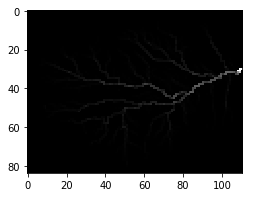

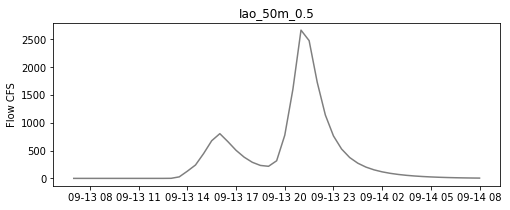

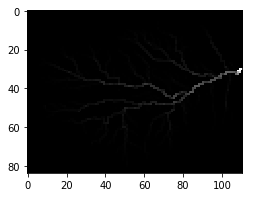

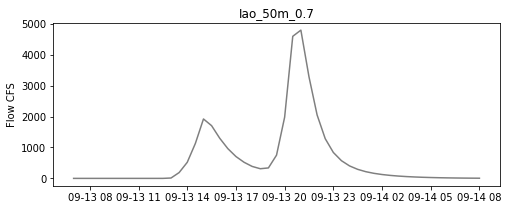

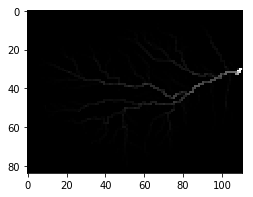

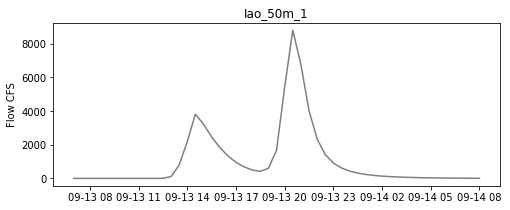

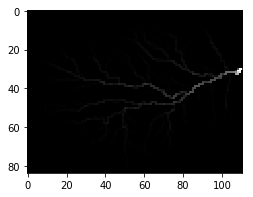

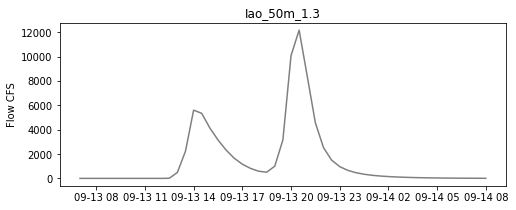

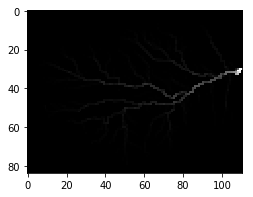

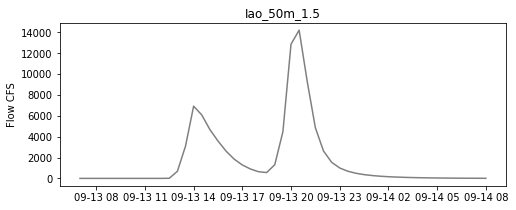

In [11]:
multiplier_list = [0.5, 0.7, 1, 1.3, 1.5] 
# 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2] 

for multiplier in multiplier_list: 
    Input_Precip_df = pd.read_csv(Input_Precip_File, index_col=0, parse_dates=True)   # read in data 

    # Here is the factor multiplier
    Input_Precip_df['RF_mm']  = Input_Precip_df['RF_mm'] * multiplier


    # Rewrite Gag file and make run length the same as the file 
    Total_Run_Length, Rain_Data_Frame = make_rain_gag_file(PrjName, 
                       Input_Precip_df, Precip_column_Name, StartDate, EndDate, 
                       Lat, Lon, RainSeries_timestep_Mins, ImpPrecip_units="mm")

    ##### RUN GSSHA    ######
    elapsed = run_GSSHA(PrjName, RUN_dir)

    ## Postprocessing and plotting 
    Save_RUN_name       = "{}_{}".format(SaveName, str(multiplier))
    
    
    Save_FilePlace = os.path.join(Save_Folder, "MaxFloodMaps")
    WMS_Max_Flood_File_to_ASCii(gfl_file, NumRowsCells, NumCols_Cells,
                               cellsize, xll, yll, no_data_val, Save_RUN_name, Save_FilePlace, 
                                    PLOT=True, SAVE=True)

    # Processs Outlet Hydrograph   
    OutHydro = process_otl_file(StartDate, PrjName)   # Process output hydrograph
    
    # Plot Hydrograph
    fig, ax = plt.subplots(figsize=(8, 3))
    lns2 = ax.plot(OutHydro['CFS'], '-', c='k', alpha=0.5, label="Modeled_CFS")   # plot modeled 
    ax.set_ylabel("Flow CFS")  
    plt.title(Save_RUN_name)
    plt.savefig(os.path.join(Save_Folder, "hydrograph_figs", '{}.png'.format(Save_RUN_name)))
    
    # Save All Hydrograph as a table 
    OutHydro = OutHydro[['CFS']]
    OutHydro = OutHydro.rename(columns={'CFS': Save_RUN_name})

    # Automatically append the new column onto the save frame 
    MergeFrame = pd.concat([MergeFrame, OutHydro], axis=1)

    MergeFrame.to_csv(os.path.join(Save_Folder,  "Tabular_Results_{}.csv".format(SaveName)))
                      


<IPython.core.display.Javascript object>


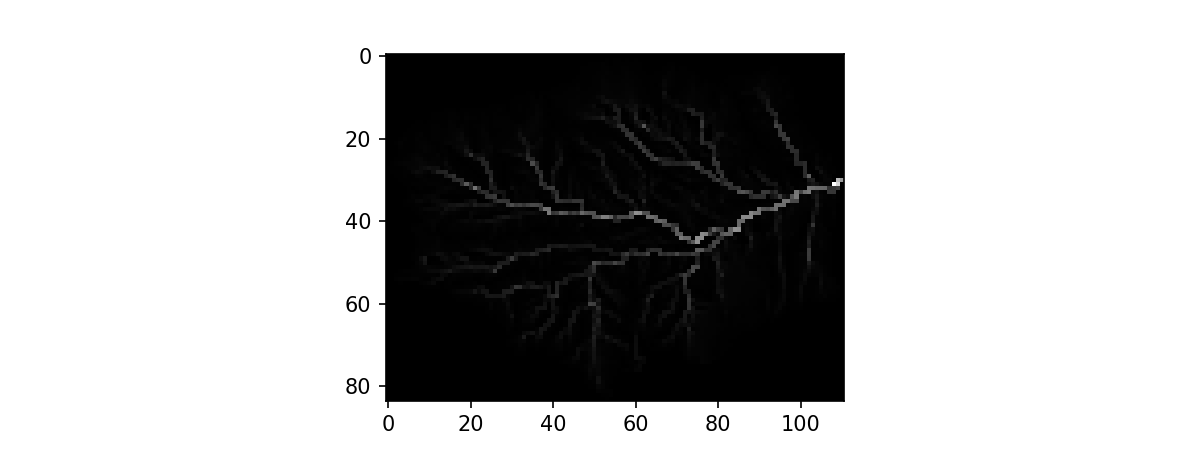

Saved Iao_50m_0.2.asc at .\Results\Iao_50m\MaxFloodMaps


<IPython.core.display.Javascript object>


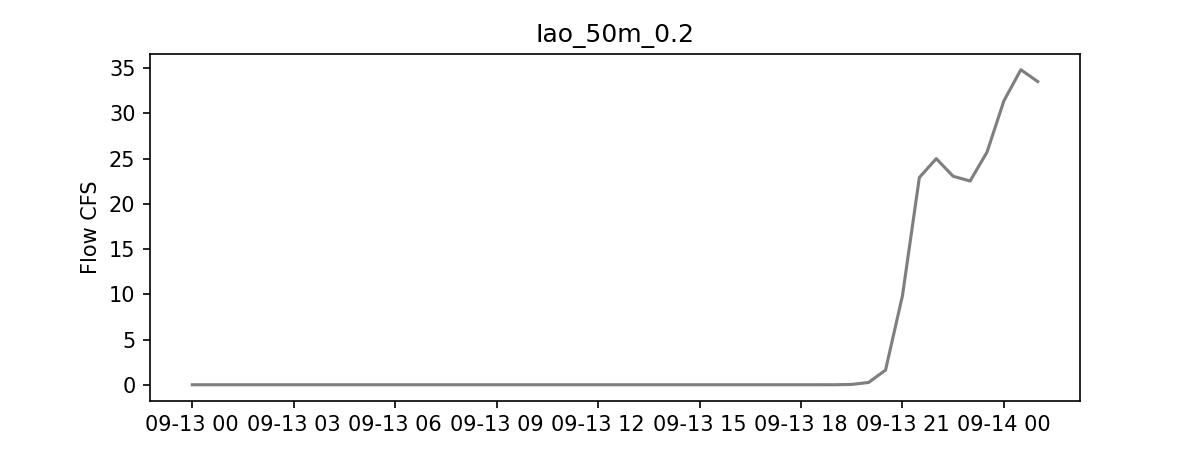

In [7]:
multiplier =0.2

Input_Precip_df = pd.read_csv(Input_Precip_File, index_col=0, parse_dates=True)   # read in data 

# Here is the factor multiplier
Input_Precip_df['RF_mm']  = Input_Precip_df['RF_mm'] * multiplier


# Rewrite Gag file and make run length the same as the file 
Total_Run_Length, Rain_Data_Frame = make_rain_gag_file(PrjName, 
                   Input_Precip_df, Precip_column_Name, StartDate, EndDate, 
                   Lat, Lon, RainSeries_timestep_Mins, ImpPrecip_units="mm")

##### RUN GSSHA    ######
elapsed = run_GSSHA(PrjName, RUN_dir)

## Postprocessing and plotting 
Save_RUN_name       = "{}_{}".format(SaveName, str(multiplier))


Save_FilePlace = os.path.join(Save_Folder, "MaxFloodMaps")
WMS_Max_Flood_File_to_ASCii(gfl_file, NumRowsCells, NumCols_Cells,
                           cellsize, xll, yll, no_data_val, Save_RUN_name, Save_FilePlace, 
                                PLOT=True, SAVE=True)

# Processs Outlet Hydrograph   
OutHydro = process_otl_file(StartDate, PrjName)   # Process output hydrograph

# Plot Hydrograph
fig, ax = plt.subplots(figsize=(8, 3))
lns2 = ax.plot(OutHydro['CFS'], '-', c='k', alpha=0.5, label="Modeled_CFS")   # plot modeled 
ax.set_ylabel("Flow CFS")  
plt.title(Save_RUN_name)
plt.savefig(os.path.join(Save_Folder, "hydrograph_figs", '{}.png'.format(Save_RUN_name)))

# Save All Hydrograph as a table 
OutHydro = OutHydro[['CFS']]
OutHydro = OutHydro.rename(columns={'CFS': Save_RUN_name})

# Automatically append the new column onto the save frame 
MergeFrame = pd.concat([MergeFrame, OutHydro], axis=1)

MergeFrame.to_csv(os.path.join(Save_Folder,  "Tabular_Results_{}.csv".format(SaveName)))

